In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

In [4]:
try:
    %tensorflow_version 1.x
except Exception:
    pass

import numpy as np
import tensorflow as tf

TensorFlow 1.x selected.


In [5]:
tf.reset_default_graph()

In [6]:
np.random.seed(40)
tf.set_random_seed(40)

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


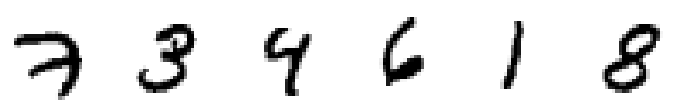

In [8]:
n_samples = 6

plt.figure(figsize=(n_samples*2, 3))

for index in range(n_samples):
    plt.subplot(1, n_samples, index+1)
    sample = mnist.train.images[index].reshape(28,28)
    plt.imshow(sample, cmap='binary')
    plt.axis("off")

plt.show()

In [9]:
mnist.train.labels[:n_samples]

array([7, 3, 4, 6, 1, 8], dtype=uint8)

In [10]:
X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name='X')

In [11]:
caps1_map = 32
caps1_amount = caps1_map * 6 * 6 #1152 Capsules
caps1_dims = 8

In [12]:
conv1_params = {
    "filters": 256,
    "kernel_size": 9,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu,
}

conv2_params = {
    "filters": caps1_amount * caps1_dims, # 256 convolutional filters
    "kernel_size": 9,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu
}

In [13]:
conv1 = tf.layers.conv2d(X, name="conv1", **conv1_params)
conv2 = tf.layers.conv2d(conv1, name="conv2", **conv2_params)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [14]:
caps1_raw = tf.reshape(conv2, [-1, caps1_amount, caps1_dims],
                       name="caps1_raw")

In [15]:
def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector

In [16]:
caps1_output = squash(caps1_raw, name="caps1_output")

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [17]:
caps2_amount = 10
caps2_dims = 16

In [19]:
init_sigma = 0.1

W_init = tf.random_normal(
    shape=(1, caps1_amount, caps2_amount, caps2_dims, caps1_dims),
    stddev=init_sigma, dtype=tf.float32, name="W_init")
W = tf.Variable(W_init, name="W")

In [20]:
batch_size = tf.shape(X)[0]
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")

In [23]:
caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                       name="caps1_output_expanded")
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2,
                                   name="caps1_output_tile")
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_amount, 1, 1],
                             name="caps1_output_tiled")

In [68]:
W_tiled

<tf.Tensor 'W_tiled:0' shape=(?, 1152, 10, 16, 8) dtype=float32>

In [24]:
caps1_output_tiled

<tf.Tensor 'caps1_output_tiled_1:0' shape=(?, 1152, 10, 8, 1) dtype=float32>

In [69]:
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled,
                            name="caps2_predicted")
caps2_predicted

<tf.Tensor 'caps2_predicted_1:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

In [26]:
raw_weights = tf.zeros([batch_size, caps1_amount, caps2_amount, 1, 1],
                       dtype=np.float32, name="raw_weights")

In [27]:
routing_weights = tf.nn.softmax(raw_weights, dim=2, name="routing_weights")

Instructions for updating:
dim is deprecated, use axis instead


In [28]:
weighted_predictions = tf.multiply(routing_weights, caps2_predicted,
                                   name="weighted_predictions")
weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keep_dims=True,
                             name="weighted_sum")

In [29]:
caps2_output_round_1 = squash(weighted_sum, axis=-2,
                              name="caps2_output_round_1")

In [70]:
caps2_predicted

<tf.Tensor 'caps2_predicted_1:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

In [30]:
caps2_output_round_1

<tf.Tensor 'caps2_output_round_1/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

In [32]:
caps2_output_round_1_tiled = tf.tile(
    caps2_output_round_1, [1, caps1_amount, 1, 1, 1],
    name="caps2_output_round_1_tiled")

In [33]:
agreement = tf.matmul(caps2_predicted, caps2_output_round_1_tiled,
                      transpose_a=True, name="agreement")

In [34]:
raw_weights_round_2 = tf.add(raw_weights, agreement,
                             name="raw_weights_round_2")

In [35]:
routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2,
                                        dim=2,
                                        name="routing_weights_round_2")
weighted_predictions_round_2 = tf.multiply(routing_weights_round_2,
                                           caps2_predicted,
                                           name="weighted_predictions_round_2")
weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2,
                                     axis=1, keep_dims=True,
                                     name="weighted_sum_round_2")
caps2_output_round_2 = squash(weighted_sum_round_2,
                              axis=-2,
                              name="caps2_output_round_2")

In [36]:
caps2_output = caps2_output_round_2

In [37]:
def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

In [38]:
y_prob = safe_norm(caps2_output, axis=-2, name="y_prob")

In [71]:
y_prob_argmax = tf.argmax(y_prob, axis=2, name="y_prob")
y_prob_argmax

<tf.Tensor 'y_prob_2:0' shape=(?, 1, 1) dtype=int64>

In [41]:
y_pred = tf.squeeze(y_prob_argmax, axis=[1,2], name="y_pred")

In [42]:
y_pred

<tf.Tensor 'y_pred:0' shape=(?,) dtype=int64>

In [43]:
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")

In [44]:
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

In [45]:
T = tf.one_hot(y, depth=caps2_amount, name="T")

In [72]:
caps2_output

<tf.Tensor 'caps2_output_round_2/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

In [47]:
caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True,
                              name="caps2_output_norm")

In [48]:
present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm),
                              name="present_error_raw")
present_error = tf.reshape(present_error_raw, shape=(-1, 10),
                           name="present_error")

In [49]:
absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus),
                             name="absent_error_raw")
absent_error = tf.reshape(absent_error_raw, shape=(-1, 10),
                          name="absent_error")

In [50]:
L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,
           name="L")

In [51]:
margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

In [52]:
mask_with_labels = tf.placeholder_with_default(False, shape=(),
                                               name="mask_with_labels")

In [53]:
reconstruction_targets = tf.cond(mask_with_labels, # condition
                                 lambda: y,        # if True
                                 lambda: y_pred,   # if False
                                 name="reconstruction_targets")

In [73]:
reconstruction_mask = tf.one_hot(reconstruction_targets,
                                 depth=caps2_amount,
                                 name="reconstruction_mask")
reconstruction_mask

<tf.Tensor 'reconstruction_mask_1:0' shape=(?, 10) dtype=float32>

In [74]:
caps2_output

<tf.Tensor 'caps2_output_round_2/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

In [56]:
reconstruction_mask_reshaped = tf.reshape(
    reconstruction_mask, [-1, 1, caps2_amount, 1, 1],
    name="reconstruction_mask_reshaped")

In [75]:
caps2_output_masked = tf.multiply(
    caps2_output, reconstruction_mask_reshaped,
    name="caps2_output_masked")
caps2_output_masked

<tf.Tensor 'caps2_output_masked_1:0' shape=(?, 1, 10, 16, 1) dtype=float32>

In [76]:
decoder_input = tf.reshape(caps2_output_masked,
                           [-1, caps2_amount * caps2_dims],
                           name="decoder_input")
decoder_input

<tf.Tensor 'decoder_input_1:0' shape=(?, 160) dtype=float32>

In [77]:
n_hidden1 = 512
n_hidden2 = 1024
n_output = 28 * 28

In [60]:
with tf.name_scope("decoder"):
    hidden1 = tf.layers.dense(decoder_input, n_hidden1,
                              activation=tf.nn.relu,
                              name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2,
                              activation=tf.nn.relu,
                              name="hidden2")
    decoder_output = tf.layers.dense(hidden2, n_output,
                                     activation=tf.nn.sigmoid,
                                     name="decoder_output")

Instructions for updating:
Use keras.layers.Dense instead.


In [61]:
X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
squared_difference = tf.square(X_flat - decoder_output,
                               name="squared_difference")
reconstruction_loss = tf.reduce_mean(squared_difference,
                                    name="reconstruction_loss")

In [62]:
alpha = 0.0005

loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")

In [64]:
correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [65]:
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name="training_op")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [66]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
n_epochs = 10
batch_size = 50
restore_checkpoint = True

n_iterations_per_epoch = mnist.train.num_examples // batch_size
n_iterations_validation = mnist.validation.num_examples // batch_size
best_loss_val = np.infty
checkpoint_path = "./my_capsule_network"

with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()

    for epoch in range(n_epochs):
        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            # Run the training operation and measure the loss:
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch,
                           mask_with_labels: True})
            print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")

        # At the end of each epoch,
        # measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch, y_batch = mnist.validation.next_batch(batch_size)
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

In [ ]:
n_samples = 5

sample_images = mnist.test.images[:n_samples].reshape([-1, 28, 28, 1])

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    caps2_output_value, decoder_output_value, y_pred_value = sess.run(
            [caps2_output, decoder_output, y_pred],
            feed_dict={X: sample_images,
                       y: np.array([], dtype=np.int64)})

In [ ]:
sample_images = sample_images.reshape(-1, 28, 28)
reconstructions = decoder_output_value.reshape([-1, 28, 28])

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(sample_images[index], cmap="binary")
    plt.title("Label:" + str(mnist.test.labels[index]))
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.title("Predicted:" + str(y_pred_value[index]))
    plt.imshow(reconstructions[index], cmap="binary")
    plt.axis("off")
    
plt.show()

In [ ]:
def tweak_pose_parameters(output_vectors, min=-0.5, max=0.5, n_steps=11):
    steps = np.linspace(min, max, n_steps) # -0.25, -0.15, ..., +0.25
    pose_parameters = np.arange(caps2_n_dims) # 0, 1, ..., 15
    tweaks = np.zeros([caps2_n_dims, n_steps, 1, 1, 1, caps2_n_dims, 1])
    tweaks[pose_parameters, :, 0, 0, 0, pose_parameters, 0] = steps
    output_vectors_expanded = output_vectors[np.newaxis, np.newaxis]
    return tweaks + output_vectors_expanded

In [ ]:
n_steps = 11

tweaked_vectors = tweak_pose_parameters(caps2_output_value, n_steps=n_steps)
tweaked_vectors_reshaped = tweaked_vectors.reshape(
    [-1, 1, caps2_n_caps, caps2_n_dims, 1])

In [ ]:
tweak_labels = np.tile(mnist.test.labels[:n_samples], caps2_n_dims * n_steps)

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    decoder_output_value = sess.run(
            decoder_output,
            feed_dict={caps2_output: tweaked_vectors_reshaped,
                       mask_with_labels: True,
                       y: tweak_labels})

In [ ]:
tweak_reconstructions = decoder_output_value.reshape(
        [caps2_n_dims, n_steps, n_samples, 28, 28])


In [ ]:
for dim in range(3):
    print("Tweaking output dimension #{}".format(dim))
    plt.figure(figsize=(n_steps / 1.2, n_samples / 1.5))
    for row in range(n_samples):
        for col in range(n_steps):
            plt.subplot(n_samples, n_steps, row * n_steps + col + 1)
            plt.imshow(tweak_reconstructions[dim, col, row], cmap="binary")
            plt.axis("off")
    plt.show()